In [ ]:
import os
import sys
from datetime import datetime
# sys.path.insert(0, "../../..")
# sys.path.insert(0, "../../../../acquire")

from Acquire.ObjectStore import datetime_to_string
from Acquire.Client import User, Drive, Service, PAR, Authorisation, StorageCreds

from HUGS.Processing import search
from HUGS.Client import Process, Search, Retrieve
from HUGS.Interface import get_map_locations, parse_data, scatter_plot, comparison_plot
from HUGS.Interface import generate_password, get_download_keys
from HUGS.Interface import search_emissions, get_emissions_data, plot_emissions

from bqplot import pyplot as plt
from bqplot import DateScale, LinearScale, LogScale, Axis, Lines, Figure, Scatter

from ipywidgets import (GridspecLayout, GridBox , VBox, HBox, HTML, Layout, Text, 
                        Button, Output, Checkbox, Label)
import ipywidgets as widget

# Welcome

This notebook allows interaction with the prototype of the HUS platform. It is currently very heavily in development and as such will change extensively in the coming months. A polished notebook interface based on [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) will be developed along with another, web-based, interface for users may not be as comfortable with Jupyer Notebooks.

Play around with the platform and please send us your feedback to [feedback@hugs-cloud.com](mailto:feedback@hugs-cloud.com)

 Enable matplotlib inline plotting

In [ ]:
%matplotlib notebook

# Remove this

In [ ]:
# Autoreload modules before executing code, useful during development
%load_ext autoreload
%autoreload 2

# Create an account

To use the HUGS service an account must be created using the Acquire authentication service. Please follow the instructions below to create your account.

Enter a username and password using the cells below

#### Password generator

In [ ]:
long_password = generate_password()
print(long_password)

4A65f7Fddb4EeE8f40D1


#### Credentials

In [ ]:
username = "gareth"
password = long_password # or create your own here

In [ ]:
base_url = "https://hugs.acquire-aaai.com/t"
result = User.register(username=username, password=password, 
                        identity_url=f"{base_url}/identity")

In [ ]:
result

{'provisioning_uri': 'otpauth://totp/identity%40hugs.acquire-aaai.com:gareth?secret=BMPWVD2Y7FFNWPHZ&issuer=identity%40hugs.acquire-aaai.com',
 'otpsecret': 'BMPWVD2Y7FFNWPHZ',
 'qrcode': <qrcode.image.pil.PilImage at 0x7f0058301810>}

## OTP QR code

Run the cell below to create a QR code to scan using an authenticator app such as AndOTP or Google Authenticator

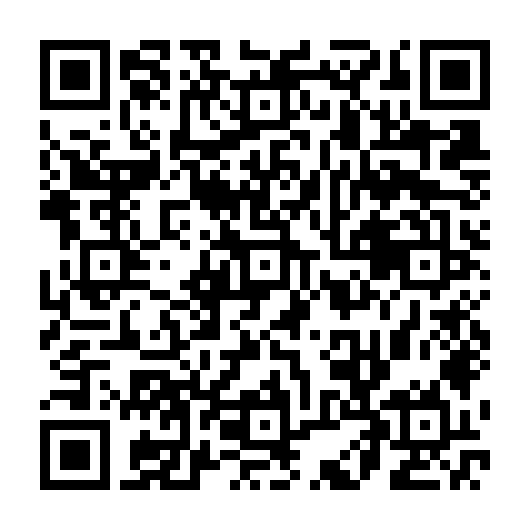

In [ ]:
result["qrcode"]

## Login

You are now ready to login to the HUGS platform

In [ ]:
username = "gareth"

In [ ]:
user = User(username=username, identity_url=f"{base_url}/identity")

In [ ]:
result = user.request_login()

Login by visiting: https://login.acquire-aaai.com?id=a0-a6/29.55.55.81
(please check that this page displays the message 'small cats run slowly')


#### Check that we've been logged in

In [ ]:
user.wait_for_login()

# Searching

### To search

1. `search_terms` - a `list` of species to search for. To search for all species or locations simply pass an empty list.
  

2. `search_locations` - a `list` of locations / sites to search for. 
For example `bsd` or `Bilsdale`.
    
3. `data_type` - For example `CRDS` or `GC`
4. `start`, `end` - Python datetime objects 



In [ ]:
base_url = "https://hugs.acquire-aaai.com/t"
search = Search(service_url=base_url)

# A list of species names
search_terms = []
# A list of locations
search_locations = []
data_type = "CRDS"

start = datetime(1970, 1,1)
end = datetime.now()

search_results = search.search(search_terms=search_terms, locations=search_locations, 
                               data_type=data_type, start_datetime=start, end_datetime=end)


[] []


In [ ]:
search_results.keys()

dict_keys(['bsd_ch4', 'bsd_co2', 'bsd_co', 'hfd_ch4', 'hfd_co2', 'hfd_co', 'tac_ch4', 'tac_co2'])

### Map of locations

Here we utilise the [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/) library to create a map marked with the locations of the sites available. You may click on the marked locations to see details about the data held for these sites.

In [ ]:
get_map_locations(search_results)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Playing with the data

In [ ]:
to_download = ["bsd_co", "hfd_co", "bsd_co2", "hfd_co2"]

Create a Retrieve object so we can interact with the data stored in the cloud.

In [ ]:
retrieve = Retrieve(service_url=base_url)

From the search results we can select the keys for the data we want to work with using the `get_download_keys` function. We just pass it a list containing the keys we want to download and it returns an object we can give to the `retrieve` function.

In [ ]:
download_keys = get_download_keys(search_results, to_download)
data = parse_data(retrieve.retrieve(keys=download_keys))

In [ ]:
bsd_data = data["bsd_co"]
scatter_plot(bsd_data)

Figure(animation_duration=1000, axes=[Axis(label='Date', scale=DateScale()), Axis(label='Count', orientation='…

In [ ]:
comparison_plot(data, ["hfd_co", "hfd_co2"])


Figure(animation_duration=1000, axes=[Axis(label='Date', scale=DateScale()), Axis(label='Count', orientation='…

## Raw plotting - use bqplot

The quick plots created above were created using [bqplot](https://github.com/bloomberg/bqplot/). You are free to use the plotting library of your choice to plot the data provided by the platform. For time-series data the data is provided as `Pandas.DataFrame` objects.


We'll now plot multiple gases and place these plots into a single figure

In [ ]:
# A list of species names
search_terms = ["H-2402","CH3Cl","CH2Cl2","HFC-152a"]
# A list of locations
search_locations = ["capegrim"]
data_type = "GC"

start = datetime(1970, 1,1)
end = datetime.now()

search_results = search.search(search_terms=search_terms, locations=search_locations, 
                               data_type=data_type, start_datetime=start, end_datetime=end)

['H-2402', 'CH3Cl', 'CH2Cl2', 'HFC-152a'] ['capegrim']


In [ ]:
search_results.keys()

dict_keys(['capegrim_H-2402', 'capegrim_CH3Cl', 'capegrim_CH2Cl2', 'capegrim_HFC-152a'])

In [ ]:
to_download = ["capegrim_H-2402", "capegrim_CH3Cl", "capegrim_CH2Cl2", "capegrim_HFC-152a"]
download_keys = get_download_keys(search_results, to_download)
data = parse_data(retrieve.retrieve(keys=download_keys))


In [ ]:
H2402_data = data["capegrim_H-2402"]["H-2402"]
CH3Cl_data = data["capegrim_CH3Cl"]["CH3Cl"]
CH2Cl2_data = data["capegrim_CH2Cl2"]["CH2Cl2"]
HFC152a_data = data["capegrim_HFC-152a"]["HFC-152a"]

In [ ]:
x_scale = DateScale()
y_scale = LinearScale()
date_line_scales = {"x": DateScale(), "y": LinearScale()}

ax = Axis(label="Date", scale=x_scale)
ay = Axis(label="Count", scale=y_scale, orientation="vertical")

H2402_lines= Lines(x=H2402_data.index, y=H2402_data, scales={"x": DateScale(), "y": LinearScale()})
H2402_fig = Figure(marks=[H2402_lines], axes=[ax,ay], title="H2402")

CH3Cl_lines= Lines(x=CH3Cl_data.index, y=CH3Cl_data, scales={"x": DateScale(), "y": LinearScale()})
CH3Cl_fig = Figure(marks=[CH3Cl_lines], axes=[ax,ay], title="CH3Cl")

CH2Cl2_lines= Lines(x=CH2Cl2_data.index, y=CH2Cl2_data, scales={"x": DateScale(), "y": LinearScale()})
CH2Cl2_fig = Figure(marks=[CH2Cl2_lines], axes=[ax,ay], title="CH2Cl2")

HFC152a_lines = Lines(x=HFC152a_data.index, y=HFC152a_data, scales={"x": DateScale(), "y": LinearScale()})
HFC152a_fig = Figure(marks=[HFC152a_lines], axes=[ax,ay], title="HFC152a")

top_line = HBox(children=[H2402_fig, CH3Cl_fig])
bot_line = HBox(children=[CH2Cl2_fig, HFC152a_fig])

grid = VBox(children=[top_line, bot_line])
grid

## Plot emissions maps

In [ ]:
# Empty search terms, show all data
search_terms = []
results = search_emissions(search_terms=search_terms)
print(results)

NameError: name 'search_emissions' is not defined

In [ ]:
data = get_emissions_data(results[0])

plot_emissions(data)

### Hide all the download keys etc from the user and just give a table of things to plot

### Select the things to plot, return VBox's etc from plotting functions?

In [ ]:
from ipyleaflet import (
    Map,
    Marker, MarkerCluster, TileLayer, ImageOverlay, GeoJSON,
    Polyline, Polygon, Rectangle, Circle, CircleMarker, Popup,
    SplitMapControl, WidgetControl,
    basemaps, basemap_to_tiles
)

from ipywidgets import HTML

In [ ]:
center = [54.2361, -4.548]
zoom = 5
m = Map(center=center, zoom=zoom)
mark_bsd = Marker(location=(54.942544, -1.369204))
mark_bsd.popup = HTML(value="Bilsdale")

mark_mhd = Marker(location=(53.20,-9.54))
mark_mhd.popup = HTML(value="Macehead")

mark_tac = Marker(location=(52.511, 1.155003))
mark_tac.popup = HTML(value="Tacolneston")

m += mark_bsd
m += mark_mhd
m += mark_tac

display(m)